# X-inactivation Preprocess

This notebook prepares a part of the Lupus dataset for detection of X-inactivation.

1. Get "SLEcrossX_nonorm.h5ad" from Ricahrd (Google Drive).
2. Filter for donors that we have metadata for in cluestime1.csv from Meena.
3. Filter for genes that have a certain cell count (5000).
4. Filter for cells from batch 1.
5. Save the data

In [1]:
import pandas as pd
import scanpy.api as sc
import numpy as np

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/x_inactivation_data/'

### Read the fullly annotated, processes AnnData and save the metadata

In [3]:
#adata_annotated = sc.read(data_path + 'CLUESImmVar_processed.V6.4.11.2019.annotated.h5ad')


In [5]:
#adata_annotated.var.to_csv(data_path + 'processed_genes.csv')

In [4]:
# adata_annotated.obs.to_csv(data_path + 'processed_metadata.csv')

### Read the raw AnnData and filter

1. Cell should be present in the final processed version
2. It should come from the CLUES dataset

In [6]:
adata_nonorm = sc.read(data_path + 'CLUESImmVar_nonorm.V6.h5ad')

In [7]:
metadata = pd.read_csv(data_path + 'processed_metadata.csv', index_col=0)

In [8]:
adata = adata_nonorm[metadata.index].copy()

In [9]:
adata.obs = metadata.copy()

### Do some sanity checks by computing PCs

Make sure they separate by cell type

In [29]:
adata_sample = adata.copy()

In [30]:
sc.pp.subsample(adata_sample, n_obs=5000)

In [31]:
sc.pp.filter_genes(adata_sample, min_cells=5)

In [32]:
mito_genes = adata_sample.var_names.str.startswith('MT-')
adata_sample.obs['percent_mito'] = np.sum(
    adata_sample[:, mito_genes].X, axis=1).A1 / np.sum(adata_sample.X, axis=1).A1
adata_sample.obs['n_counts'] = adata_sample.X.sum(axis=1).A1

In [33]:
adata_sample = adata_sample[adata_sample.obs['n_genes'] < 2500, :]
adata_sample = adata_sample[adata_sample.obs['percent_mito'] < 0.05, :]

In [34]:
sc.pp.normalize_per_cell(adata_sample, counts_per_cell_after=1e4)

In [35]:
sc.pp.log1p(adata_sample)

In [36]:
sc.pp.filter_genes_dispersion(adata_sample, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [37]:
sc.pp.regress_out(adata_sample, ['n_counts', 'percent_mito'])

In [18]:
sc.pp.regress_out(adata_sample, 'batch_cov')

In [38]:
sc.pp.scale(adata_sample, max_value=10)

In [39]:
sc.tl.pca(adata_sample, svd_solver='arpack')

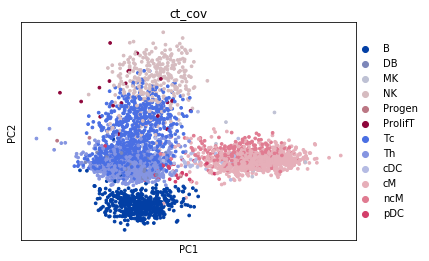

In [40]:
sc.pl.pca(adata_sample, color='ct_cov')

### Filter the genes

In [12]:
gene_metadata = pd.read_csv(data_path + 'processed_genes.csv', index_col=0)


In [15]:
adata = adata[:, gene_metadata.index].copy()

In [11]:
adata.shape

(775678, 32738)

### Check distribution of genders

In [16]:
adata.obs.groupby(['Female', 'ind_cov']).size()

Female  ind_cov            
0.0     1051_1051              3103
        1195_1195              3761
        1196_1196              3838
        1221_1221              4867
        1414_1414              4401
        1522_1522              5111
        1558_1558              4445
        1615_1615              5053
        1621_1621              5317
        901911200_901911200    4298
        902299200_902299200    3397
        903965200_903965200    5926
        904344200_904344200    5012
        904477200_904477200    4083
1.0     1004_1004              3198
        1014_1014              3308
        1019_1019              4403
        1045_1045              3604
        1054_1054              4105
        1056_1056              4902
        1078_1078              3320
        1110_1110              4228
        1127_1127              4044
        1132_1132              4847
        1197_1197              4713
        1203_1203              5330
        1219_1219              4744


In [17]:
sc.write(data_path + 'lupus_annotated_nonorm_V6.h5ad', adata)

... storing 'disease_cov' as categorical
... storing 'ct_cov' as categorical
... storing 'pop_cov' as categorical
... storing 'ind_cov' as categorical
... storing 'well' as categorical
... storing 'batch_cov' as categorical
